# Gen data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import random
import os
sys.path.append("..")
from global_variables import *
from escape_map import EscapeMap, load_escape_map_from_csv,gen_artif_data, score_seq_batch
from utils import get_Kd

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors
Loaded 438 KD vectors


In [2]:
#import utils from ../rbm
pgm_dir=('../')
sys.path.append(pgm_dir+'./utilities')

# Now safe to import
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils  # rbm.py must be alongside this file

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd




# Escape Score

In [4]:
# seqs=Proteins_utils.load_FASTA('generated_sequences_beta3.fasta', drop_duplicates=False)
#read generated_sequences_ace2tensor(-9.3000)_betatensor(-0.4463).pkl
seqs=np.load(open('generated_sequences_ace2tensor(-9.3000)_betatensor(-0.4463).npy','rb'))
MERGED_KD_VECTORS=KD_VECTORS | NEW_KD_VECTORS
seqs.shape


(1000, 178)

In [5]:
log_kd_values=np.array([get_Kd(seq,MERGED_KD_VECTORS , log10=True) for seq in seqs])

log_kd_values.shape#nseeq, n_ab

(1000, 31)

In [6]:
ab_class_df_mapping=pd.read_csv('../exp_data/ab_classification.csv')
class_mapping = ab_class_df_mapping.set_index('condition')['condition_subtype'].to_dict()#condition is antibody name, condition_subtype is class
#add VIR-7229: class 1 and SA44: class 4
class_mapping['VIR-7229'] = 'class 1'
class_mapping['SA55'] = 'class 4'
ab_names=list(MERGED_KD_VECTORS.keys())#ab_names#name of antibodies
#create a dataframe conaining name of antibodies and their class obtained from the mapping
ab_class_df=pd.DataFrame({'antibody':ab_names})
ab_class_df['class'] = ab_class_df['antibody'].map(class_mapping)
ab_class_df


,antibody,class
0,COV2-2050,class 2
1,COV2-2082,class 4
2,COV2-2094,class 4
3,COV2-2096,class 2
4,COV2-2130,class 3
5,COV2-2165,class 1
6,COV2-2196,class 1
7,COV2-2479,class 2
8,COV2-2499,class 3
9,COV2-2677,class 4


(1000, 31)


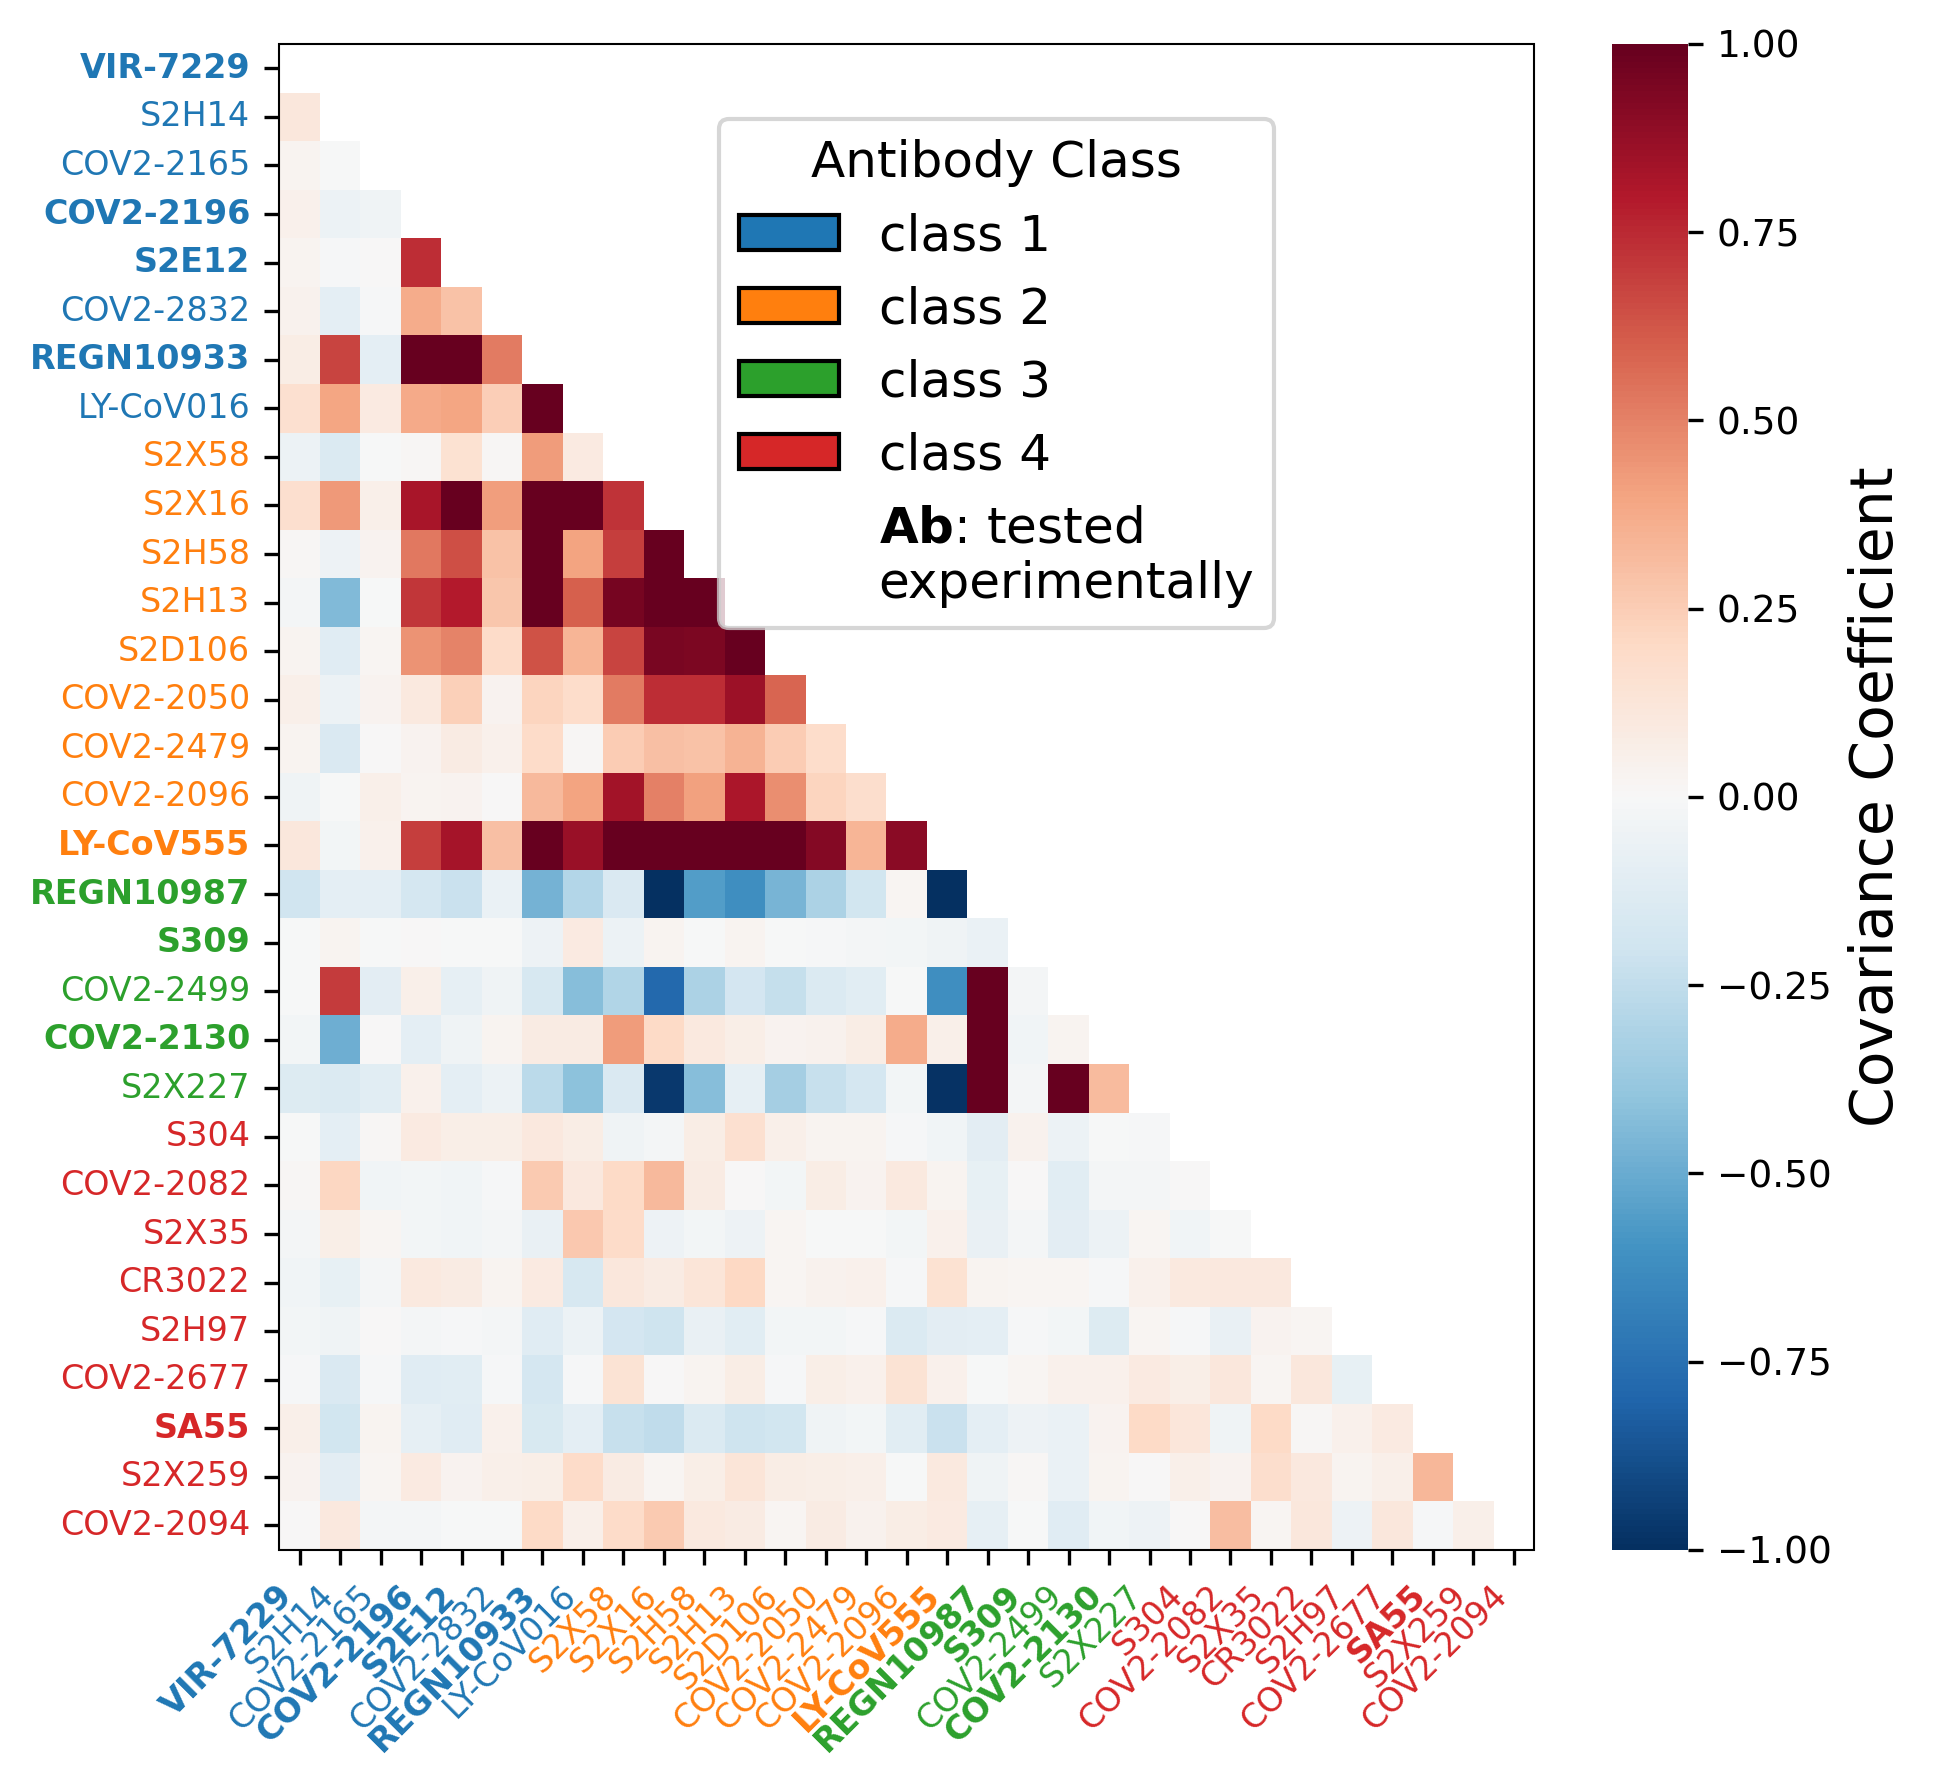

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.patches as patches



# Step 1: Create DataFrame for antibodies and their classes
ab_class_df = pd.DataFrame({'antibody': ab_names})
ab_class_df['class'] = ab_class_df['antibody'].map(class_mapping)

# Step 2: Calculate the correlation matrix
import numpy as np
import pandas as pd

# Build the DataFrame
if isinstance(log_kd_values, np.ndarray):
    df_log_kd = pd.DataFrame(log_kd_values, columns=ab_names)
else:
    # keep only the antibodies we care about, in order
    df_log_kd = log_kd_values.loc[:, ab_names]

# ensure numeric and drop rows that are all NaN across selected columns
df_log_kd = df_log_kd.apply(pd.to_numeric, errors='coerce')

# (optional) choose how to handle NaNs:
# df_log_kd = df_log_kd.dropna(how="any")      # strict: drop any row with NaN
# df_log_kd = df_log_kd.dropna(how="all")      # lenient: drop rows that are all NaN

# Mean per antibody (unchanged)
k_wt = df_log_kd.mean()

# One-liner: sample covariance matrix (ddof=1, pairwise complete obs)
covariance_matrix = df_log_kd.cov()

print(df_log_kd.shape)


# Step 3: Sort by class
ab_class_df_sorted = ab_class_df.sort_values(by='class')
sorted_ab_names = ab_class_df_sorted['antibody'].tolist()
sorted_corr_matrix = covariance_matrix.loc[sorted_ab_names, sorted_ab_names]
sorted_corr_matrix = sorted_corr_matrix.astype(float)
sorted_corr_matrix.fillna(0, inplace=True)

# Step 4: Create mask and grey out diagonal
mask = np.triu(np.ones_like(sorted_corr_matrix, dtype=bool), k=1)  # upper triangle mask
np.fill_diagonal(sorted_corr_matrix.values, np.nan)  # diagonal to NaN

# Create custom colormap with grey for NaNs
cmap = plt.get_cmap('RdBu_r')

cmap.set_bad(color='white')

# Define class colors
class_colors = ab_class_df_sorted['class'].drop_duplicates().reset_index(drop=True)
color_map = {k: f"C{i}" for i, k in enumerate(class_colors)}

# Step 5: Plot
plt.figure(figsize=(6.5, 6), dpi=300)
ax = sns.heatmap(
    sorted_corr_matrix,
    annot=False,
    cmap=cmap,
    xticklabels=sorted_ab_names,
    yticklabels=sorted_ab_names,
    vmin=-1,
    vmax=1,
    mask=mask,
    cbar_kws={'label': 'Correlation Coefficient'}
)

# Set the font size of the colorbar label
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Covariance Coefficient', fontsize=14)

# Define class legend elements
legend_elements = [
    Patch(facecolor=color_map[class_name], edgecolor='black', label=class_name)
    for class_name in color_map
]
legend_elements.append(
Patch(
    facecolor='none',
    edgecolor='none',
    label="$\\bf{Ab}$: tested\nexperimentally"
))
# Add legend outside the heatmap
ax.legend(
    handles=legend_elements,
    title="Antibody Class",
    bbox_to_anchor=(0.35, 0.95),
    loc='upper left',
    borderaxespad=0.,
    fontsize=12,
    title_fontsize=12
)

# Color axis labels by class, and bold specific antibody names
highlight_abs = {"S2E12", "REGN10933", "COV2-2196", "VIR-7229", "LY-CoV555", "S309", "COV2-2130", "REGN10987", "SA55"}

xticks = ax.get_xticklabels()
yticks = ax.get_yticklabels()

for i, tick in enumerate(xticks):
    ab = ab_class_df_sorted.iloc[i]['antibody']
    tick.set_color(color_map[ab_class_df_sorted.iloc[i]['class']])
    if ab in highlight_abs:
        tick.set_fontweight('bold')

for i, tick in enumerate(yticks):
    ab = ab_class_df_sorted.iloc[i]['antibody']
    tick.set_color(color_map[ab_class_df_sorted.iloc[i]['class']])
    if ab in highlight_abs:
        tick.set_fontweight('bold')

ax.set_xticklabels(xticks, rotation=45, horizontalalignment='right')
ax.set_yticklabels(yticks, rotation=0, horizontalalignment='right')
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

# Add black frame around the heatmap matrix
num_labels = len(sorted_ab_names)
rect = patches.Rectangle(
    (0, 0),                         # bottom-left corner in data coords
    width=num_labels,              # width of the matrix
    height=num_labels,             # height of the matrix
    linewidth=0.5,
    edgecolor='black',
    facecolor='none',
    clip_on=False                  # ensures full visibility of the frame
)
ax.add_patch(rect)

plt.tight_layout()
plt.show()


C:\Users\maria\AppData\Local\Temp\ipykernel_5124\2890678148.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\maria\AppData\Local\Temp\ipykernel_5124\2890678148.py:64: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


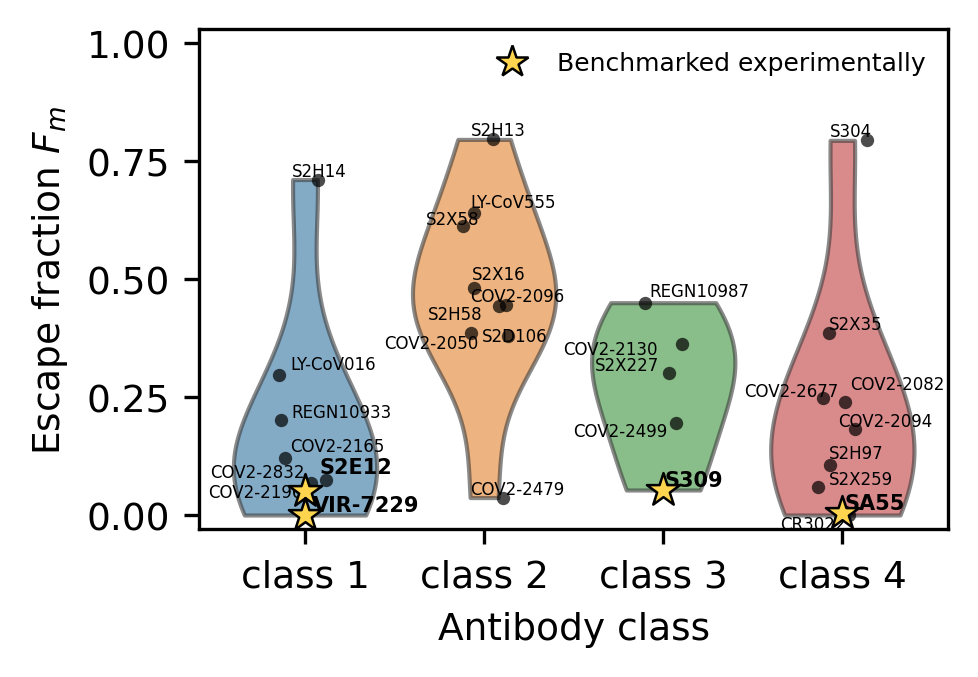

In [13]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.text import Annotation

# --- Nature-like rc ---
mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.family": "DejaVu Sans",
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.linewidth": 0.8,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
})

# --- Data prepped above ---
arr = np.asarray(log_kd_values, dtype=float)
is_valid = ~np.isnan(arr)
is_above = (arr > -6) & is_valid

denom = is_valid.sum(axis=0)
num = is_above.sum(axis=0)
with np.errstate(invalid='ignore', divide='ignore'):
    frac = np.where(denom > 0, num / denom, np.nan)

kd_df = pd.DataFrame({"antibody": ab_names, "percentage": frac})
ab_class_df = pd.DataFrame({"antibody": ab_names})
ab_class_df["class"] = ab_class_df["antibody"].map(class_mapping)

merged_df = (
    kd_df.merge(ab_class_df, on="antibody", how="left")
         .dropna(subset=["class"])
         .reset_index(drop=True)
)

# --- Visual constants ---
# Color-blind-safe palette
class_colors = {
    "class 1": "#1f77b4",   # blue
    "class 2": "#ff7f0e",   # orange
    "class 3": "#2ca02c",   # green
    "class 4": "#d62728",   # red
}
wanted_order = ["class 1", "class 2", "class 3", "class 4"]
class_order = [c for c in wanted_order if c in merged_df["class"].unique()]

# Antibodies to highlight
exclude_abs = ["S309", "S2E12", "VIR-7229", "SA55"]

fig = plt.figure(figsize=(3.3, 2.3))
ax = plt.gca()

# --- Violin per class (width-scaled, no inner bars) ---
sns.violinplot(
    x="class", y="percentage", data=merged_df, order=class_order,
    palette=class_colors, inner=None, linewidth=1.0, cut=0, scale="width", ax=ax, alpha=0.6
)

# --- Scatter of individual antibodies (except highlighted) ---
filtered_df = merged_df[~merged_df["antibody"].isin(exclude_abs)]
sns.stripplot(
    x="class", y="percentage", data=filtered_df, order=class_order,
    jitter=0.15, size=3.2, color="black", alpha=0.7, zorder=3, ax=ax
)

# --- Highlighted antibodies: stars + labels ---
highlight_df = merged_df[merged_df["antibody"].isin(exclude_abs)]
texts = []
for _, row in highlight_df.iterrows():
    x_pos = class_order.index(row["class"])
    ax.scatter(x_pos, row["percentage"], marker="*", s=70,
               facecolor="#FFD54F", edgecolor="black", linewidth=0.6, zorder=4)
    texts.append(
        ax.text(x_pos, row["percentage"] + 0.02, row["antibody"],
                fontsize=5.0, weight="bold", ha="center", va="bottom",
                bbox=dict(facecolor="none", edgecolor="none", alpha=0.85, pad=1.2))
    )

# (Optional) light labels for the rest — comment out if too busy
label_df = filtered_df
for _, row in label_df.iterrows():
    x_pos = class_order.index(row["class"])
    t = Annotation(text=row["antibody"], xy=(x_pos, row["percentage"]),
                   xytext=(x_pos - 0.02, row["percentage"]),
                   textcoords="data", ha="center", fontsize=4.0, color="black")
    ax.add_artist(t); texts.append(t)

# Tidy overlaps for any added text
if texts:
    adjust_text(texts, only_move={'points': 'xy'}, force_points=6.0)

# --- Axes, ticks, legend ---
ax.set_xlabel("Antibody class")
ax.set_ylabel(r"Escape fraction $F_m$")
ax.set_ylim(-0.03, 1.03)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])

# Remove top/right spines for a clean look
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

# Legend for highlighted points
star = plt.Line2D([0], [0], marker="*", linestyle="", markersize=8,
                  markerfacecolor="#FFD54F", markeredgecolor="black",
                  markeredgewidth=0.6, label="Benchmarked experimentally")
leg = ax.legend(handles=[star], loc="upper right", frameon=False, fontsize=6)

fig.tight_layout()
plt.show()


# Entropy

gen_seq (1000, 178)
rbd_df (3704, 178)
     site  escape_count
0     349             0
1     350             0
2     351             0
3     352             0
4     353             0
..    ...           ...
173   522             0
174   523             0
175   524             0
176   525             0
177   526             0

[178 rows x 2 columns]


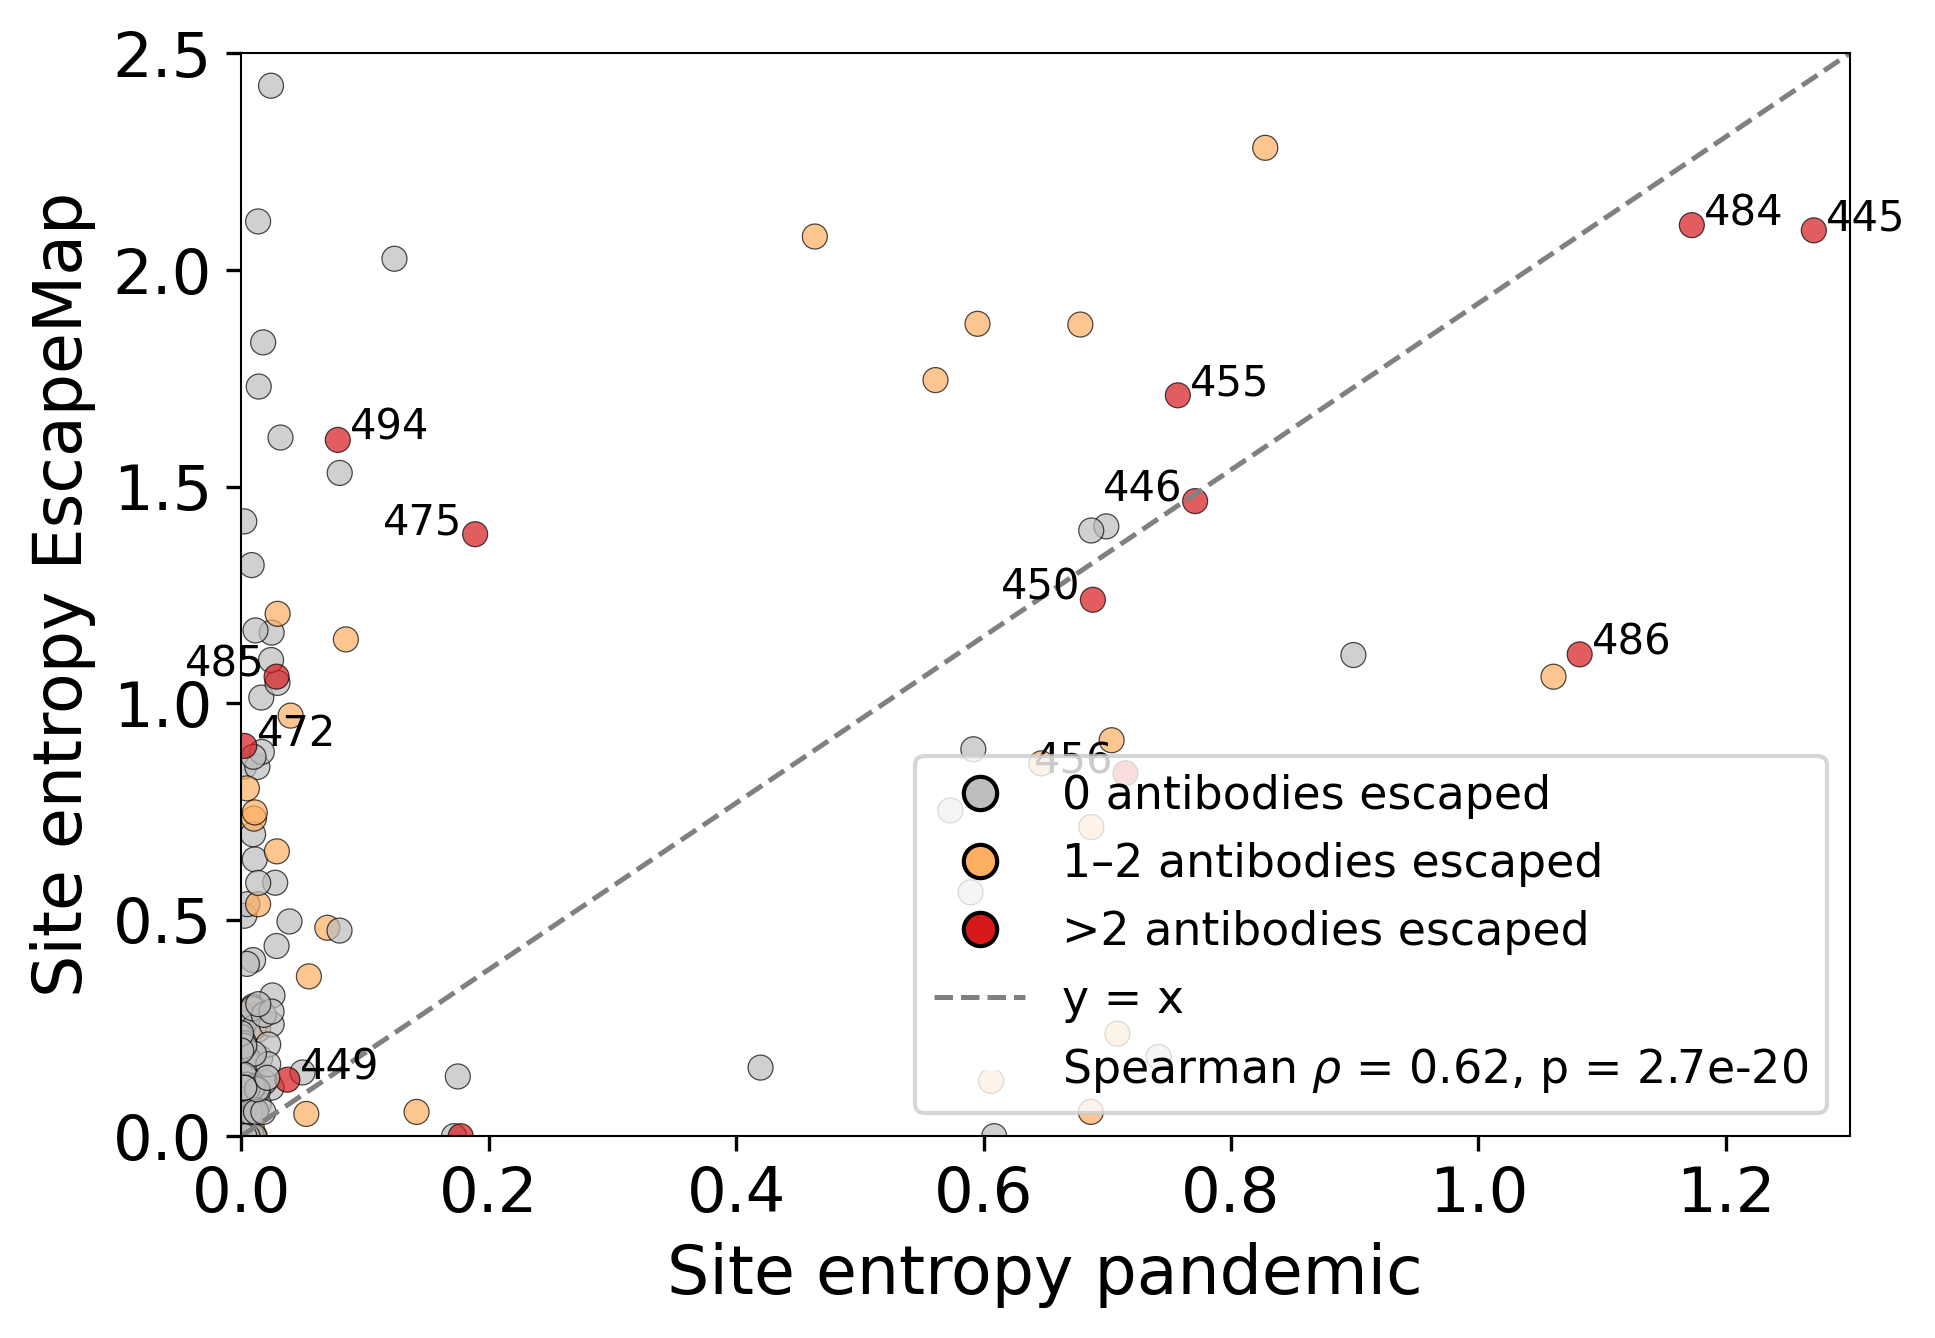

mean_entropy 0.4902236


In [14]:
gen_seq=np.load(open('generated_sequences_ace2tensor(-9.3000)_betatensor(-0.4463).npy','rb'))
print('gen_seq',gen_seq.shape)
rbd_df=Proteins_utils.load_FASTA('../seq_data/ns_mutated_spike.fasta', drop_duplicates=True)
print('rbd_df',rbd_df.shape)
position_weight_matrix_rbd_df = utilities.average(rbd_df,c=20) # Compute Position Weight Matrix (i.e. frequency of each amino acid at each site)
position_weight_matrix_gen_seq = utilities.average(gen_seq,c=20) # Same for artificial sequences.




# Compute Shannon entropy for each site
def compute_entropy(pwm):
    entropy = -np.sum(pwm * np.log(pwm + 1e-6), axis=1)
    return entropy

entropy_gisaid = compute_entropy(position_weight_matrix_rbd_df)
entropy_model = compute_entropy(position_weight_matrix_gen_seq)

# Load data
df_bloom = pd.read_csv('../exp_data/starr_nature/starr_nature_all_antibodies_raw_data.csv', sep=',')

# Antibody list
antibody_names = [
    'S2H14', 'S2E12', 'COV2-2832', 'COV2-2196', 'COV2-2165', 'REGN10933',
    'COV2-2096', 'COV2-2479', 'S2X58', 'S2X16', 'S2H58', 'LY-CoV555',
    'COV2-2050', 'S2H13', 'S2D106', 'S2X227', 'S309', 'REGN10987',
    'COV2-2499', 'COV2-2130', 'S304', 'CR3022', 'S2H97', 'COV2-2094',
    'COV2-2677', 'S2X259', 'S2X35', 'COV2-2082'
]

# Initialize counter dictionary for sites 349 to 526
site_range = np.arange(349, 527)
site_escape_count = dict.fromkeys(site_range, 0)

# Count how many antibodies show escape at each site
for ab in antibody_names:
    df_ab = df_bloom[(df_bloom['condition'] == ab) & 
                     (df_bloom['site'] >= 349) & 
                     (df_bloom['site'] <= 526)]
    
    escaped_sites = df_ab[df_ab['site_max_escape'] > 0.9]['site'].unique()
    
    for site in escaped_sites:
        site_escape_count[site] += 1

# Convert to DataFrame and array
sites = np.array(sorted(site_escape_count.keys()))
escape_counts = np.array([site_escape_count[site] for site in sites])

df_escape_summary = pd.DataFrame({'site': sites, 'escape_count': escape_counts})

# Optional: print or visualize
print(df_escape_summary)

# You now have:
# - `sites`: numpy array of RBD site positions
# - `escape_counts`: number of antibodies escaping at each site
# - `df_escape_summary`: DataFrame with both

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import spearmanr

sites = np.arange(349, 527)

# Identify top 10 escape sites
top_indices = np.where(escape_counts > 2)[0]
top_sites = sites[top_indices]
top_entropy_gisaid = entropy_gisaid[top_indices]
top_entropy_model = entropy_model[top_indices]

# Categorize escape counts
escape_categories = np.zeros_like(escape_counts)
escape_categories[(escape_counts >= 1) & (escape_counts <= 2)] = 1
escape_categories[escape_counts > 2] = 2

category_colors = ['lightgray', 'gold', 'red']
category_labels = ['0 escaped', '1–2 antibodies escaped', '>2 antibodies escaped']
# Define improved colors
category_colors_map = {
    0: '#bdbdbd',     # light gray
    1: '#fdae61',     # warm orange
    2: '#d7191c'      # red
}
colors = [category_colors_map[i] for i in escape_categories]

# Create figure
fig, ax = plt.subplots(figsize=(6.5, 4.5), dpi=300)

# Main scatter
scatter = ax.scatter(
    entropy_gisaid, entropy_model,
    c=colors, alpha=0.7,
    edgecolor='black', linewidths=0.3
)

# Reference line
ax.plot([0, 1.3], [0, 2.5], color='gray', linestyle='--', linewidth=1.2)

# Axes limits and labels
ax.set_xlim(0, 1.3)
ax.set_ylim(0, 2.5)
ax.set_xlabel('Site entropy pandemic', fontsize=16)
ax.set_ylabel('Site entropy EscapeMap', fontsize=16)
ax.tick_params(axis='both', labelsize=15)

# Annotate top escape sites
for i in range(len(top_sites)):
    # dx = 5 if i % 2 == 0 else -25
    # dy = 5 if i % 3 == 0 else -10
    dx=-6*(i%2)+3
    dy=0
    if top_entropy_model[i]>0.1:
        ax.annotate(str(top_sites[i]),
                    (top_entropy_gisaid[i], top_entropy_model[i]),
                    textcoords="offset points", xytext=(dx, dy),
                    ha='left' if dx > 0 else 'right',
                    fontsize=10, color='black')

# Spearman correlation
rho, pval = spearmanr(entropy_gisaid, entropy_model)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='0 antibodies escaped',
           markerfacecolor=category_colors_map[0], markersize=8, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='1–2 antibodies escaped',
           markerfacecolor=category_colors_map[1], markersize=8, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='>2 antibodies escaped',
           markerfacecolor=category_colors_map[2], markersize=8, markeredgecolor='black'),
    Line2D([0], [0], color='gray', lw=1.2, linestyle='--', label='y = x'),
    Line2D([0], [0], color='w', label=f'Spearman $\\rho$ = {rho:.2f}, p = {pval:.1e}')
]

ax.legend(handles=legend_elements, loc='lower right', fontsize=11, frameon=True)

# Black frame
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(0.5)

# Layout and display
plt.tight_layout()
plt.show()
print('mean_entropy', entropy_model.mean())
